## Spark cluster intro Air quality examples

### Initialization
Create and attach cluster created in databricks. 12.2 LTS (includes Apache Spark 3.3.2, Scala 2.12) 

In [0]:
!python -m pip install --upgrade pip
!pip install pygal_maps_world lxml cartopy ipympl
import pygal, lxml

     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.8/270.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.7 MB/s eta 0:00:00
  Created wheel for pygal_maps_world: filename=pygal_maps_world-1.0.2-py3-none-any.whl size=278559 sha256=

In [0]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

### Reading data from AWS S3

Now we can read a small sample of data:

In [0]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-2[1-5]/*")

In [0]:
smog_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- attribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- averagingPeriod: struct (nullable = true)
 |    |-- unit: string (nullable = true)
 |    |-- value: double (nullable = true)
 |-- city: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: string (nullable = true)
 |-- date: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- raw: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: boolean (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sourceName: string (nullable = true)
 |-- sourceType: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable =

In [0]:
from pyspark.sql.functions import col, asc, desc, max, mean, row_number
import matplotlib.pyplot as plt

Zad. 1

Znajdź miasta w Polsce, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w Paryżu (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.

In [0]:
smog_df=smog_df.select("location", "city", "country","parameter", "unit", "value",\
                col("date.local").alias("date_local"),\
                col("date.utc").alias("date_utc"),\
                "coordinates.*", "averagingPeriod", "sourceName", "sourceType", "mobile")

smog_df.createOrReplaceTempView('smog')

In [0]:
query = """
    SELECT city, avg(value) as AVG_PM25
    FROM smog
    WHERE country == 'PL' AND parameter == 'pm25'
    GROUP BY city
    HAVING avg(value) < (SELECT max(value) FROM smog WHERE city == 'Paris')
    ORDER BY AVG_PM25 DESC
"""

spark.sql(query).toPandas()


,city,AVG_PM25
0,Janów Lubelski,34.269860
1,Pińczów,33.531567
2,Kazimierza Wielka,26.582130
3,Lublin,26.107758
4,Nakło nad Notecią,24.926231
...,...,...
72,Borsukowizna,8.470668
73,Żary,7.331728
74,Dębica,5.759492
75,Opole,5.465115


Zad. 2

Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 w poszczególnych miastach z całego zbioru danych. Wyniki posortuj po rosnąco datach.

In [0]:
query = """
    SELECT b.city, max(value) as MAX_PM10, a.hour_utc
    FROM (
        SELECT max(value) as MAX_PM10, SUBSTR(date_utc, 1, 13) as hour_utc
        FROM smog
        WHERE parameter == 'pm10'
        GROUP BY hour_utc
    ) as a
    JOIN (
        SELECT city, SUBSTR(date_utc, 1, 13) as hour_utc, value
        FROM smog
        WHERE parameter == 'pm10'
    ) as b
    ON a.MAX_PM10 == b.value AND a.hour_utc == b.hour_utc
    GROUP BY a.hour_utc, b.city
    ORDER BY a.hour_utc ASC
"""

max_pm10 = spark.sql(query).toPandas()
max_pm10

,city,MAX_PM10,hour_utc
0,King Cetshwayo,14.181,2018-12-07T08
1,Bojanala Platinum,0.100,2019-12-09T16
2,Ховд хот,486.000,2019-12-24T00
3,Ховд хот,386.000,2019-12-26T00
4,Дархан хот,94.000,2019-12-26T12
...,...,...,...
185,Inowrocław,773.390,2022-10-25T21
186,Faro,604.300,2022-10-25T22
187,İstanbul,211.562,2022-10-25T23
188,İstanbul,206.245,2022-10-26T00


Zad. 3

Znajdź ranking miast w Europie pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 
Podpowiedź: Wykorzystaj window functions oraz `rlike`

In [0]:
from pyspark.sql.window import Window

In [0]:
N = 5

desc_by_city = Window.partitionBy("city").orderBy(col("parameter").desc())

eu_cities = smog_df.where((col('latitude') > 35.0) & (col('latitude') < 72.0) & (col('longitude') > -25.0) & (col('longitude') < 65.0))

eu_cities_top5 = eu_cities.where(col('parameter') == 'pm25')\
                .withColumn("row_number", row_number().over(desc_by_city))\
                .filter(col('row_number') <= N)

eu_cities_avg = eu_cities_top5.groupBy('city')\
                .agg(mean('value').alias('top5_avg'))\
                .orderBy(col('top5_avg').desc())

In [0]:
pd_eu_cities_avg = eu_cities_avg.toPandas()

In [0]:
pd_eu_cities_avg

,city,top5_avg
0,Pljevlja,93.7600
1,Bijelo Polje,79.0400
2,Düzce,46.5980
3,Kraków,45.8427
4,Pristina,44.6000
...,...,...
527,Porto,0.2000
528,Évora,0.0000
529,Gjøvik,0.0000
530,Redbridge,0.0000


Zad. 4

Zwizualizuj na mapie średnie zanieczyszczenie w danym kraju dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) dla wybranych państw.

In [0]:
q_param = "pm25"
q_country = "PL"

query = f"""
    SELECT a.city, avg(value), SUBSTR(date_utc, 1, 10) as day_utc, a.longitude, a.latitude
    FROM smog as a
    LEFT JOIN (
        SELECT DISTINCT city, latitude, longitude
        FROM smog
    ) as b
    ON a.city == b.city 
    WHERE parameter == "{q_param}" AND country == "{q_country}"
    GROUP BY day_utc, a.city, a.longitude, a.latitude
"""

res4 = spark.sql(query)

In [0]:
def split_by_column(df, column):
    unique_values = sorted(list(map(lambda x: x[0], df.select(column).distinct().collect())))
    dfs = list()
    for value in unique_values:
        dfs.append(df[df[column] == value])
    return dfs

In [0]:
daily_res = split_by_column(res4, 'day_utc')

In [0]:
import plotly.graph_objects as go
import numpy as np

def plot_day(data):
    data = data.toPandas()
    fig = go.Figure(data=go.Scattergeo(
            lon = data['longitude'],
            lat = data['latitude'],
            text = data['city'],
            mode = 'markers',
            marker_color = data['avg(value)']
            ))

    fig.update_layout(
            title = f'Poland - average polution {data["city"]}',
            geo_scope='europe',
            width=1000,
            height=1000
        )
    fig.show()

In [0]:
plot_day(daily_res[0])

In [0]:
plot_day(daily_res[1])

In [0]:
plot_day(daily_res[2])

In [0]:
plot_day(daily_res[3])

In [0]:
plot_day(daily_res[4])

Zad. 5

Wykonaj przykładowe zapytanie dla danych z długiego okresu (np. całego roku). Załącz wybrane wykresy ze Spark UI (https://spark.apache.org/docs/latest/web-ui.html), np. DAG, diagram Gantta, informacje o rozmiarach danych.


In [0]:
smog_df_month = spark.read.json("s3a://openaq-fetches/realtime/2022-10-*/*")

In [0]:
smog_df_month.filter(col('parameter') == 'pm25').groupBy('country').agg(max(col('value'))).collect()

Out[86]: [Row(country='DZ', max(value)=14.0),
 Row(country='MM', max(value)=69.0),
 Row(country='LT', max(value)=27.78000068),
 Row(country='CI', max(value)=45.0),
 Row(country='FI', max(value)=52.5954958),
 Row(country='RO', max(value)=138.35370389),
 Row(country='LA', max(value)=985.0),
 Row(country='NL', max(value)=54.4),
 Row(country='MN', max(value)=132.0),
 Row(country='PL', max(value)=490.244),
 Row(country='MK', max(value)=73.72),
 Row(country='MX', max(value)=89.4),
 Row(country='CN', max(value)=985.0),
 Row(country='AT', max(value)=74.95849609),
 Row(country='TI', max(value)=432.0),
 Row(country='IQ', max(value)=737.0),
 Row(country='99', max(value)=102.0),
 Row(country='HR', max(value)=51.3),
 Row(country='CZ', max(value)=111.0),
 Row(country='NP', max(value)=456.0),
 Row(country='UC', max(value)=41.0),
 Row(country='PT', max(value)=118.0),
 Row(country='GH', max(value)=65.0),
 Row(country='HK', max(value)=75.7),
 Row(country='SU', max(value)=240.0),
 Row(country='BD', max(v

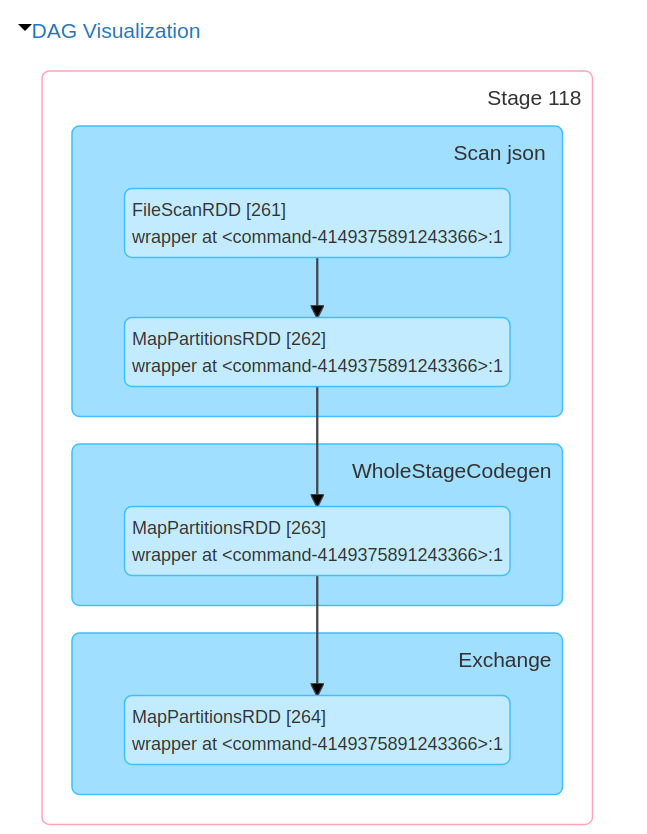
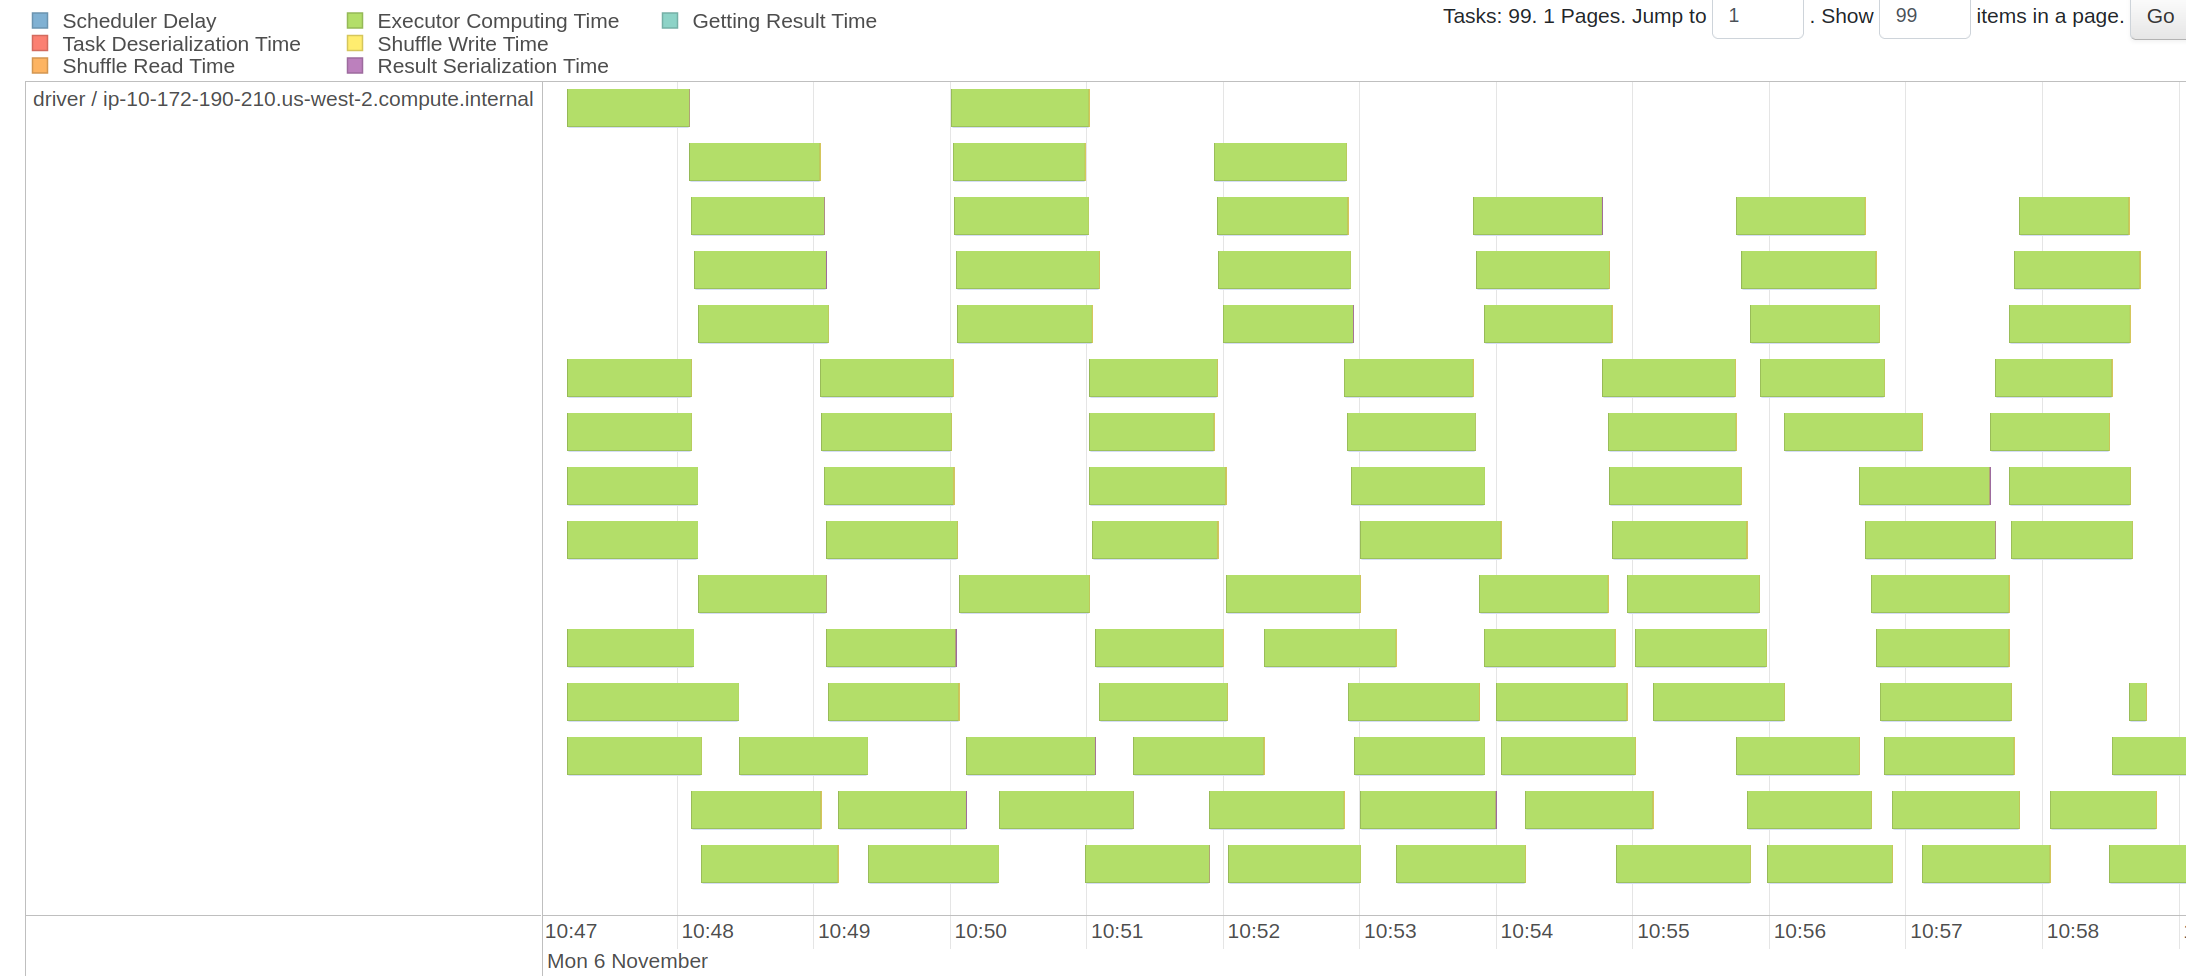
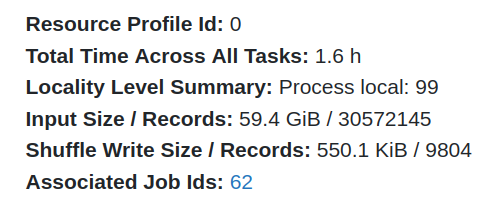